<a href="https://colab.research.google.com/github/045t/045t/blob/main/Portafolio%20de%20Markowitz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
!pip install yfinance
!pip install PyPortfolioOpt
!pip install pandas_datareader
!pip install pulp

In [52]:
import json
import os
import tempfile

import cvxpy as cp
import numpy as np
import pandas as pd
import pytest
import yfinance as yf
import matplotlib.pyplot as plt


from pypfopt import EfficientFrontier, exceptions, objective_functions
from pypfopt.base_optimizer import BaseOptimizer, portfolio_performance

from datetime import datetime
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
#pip install pandas_datareader –––-> Para instalar el paquete pandas_datereader.
from pandas_datareader import data
from pulp import *

In [53]:
Symbol = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN','^GSPC'] #ticker de los stocks

In [54]:
vol_period = 1
ticker_period = 'max'

In [55]:
#creación del dataframe con los precios de los activos
data = pd.DataFrame()

for stock in Symbol:
  ticker = stock
  data[stock] = yf.download(tickers=ticker, period=ticker_period)['Close']

print(data)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                  AAPL        MSFT        NVDA       GOOGL        AMZN  \
Date                                                                     
1980-12-12    0.128348         NaN         NaN         NaN         NaN   
1980-12-15    0.121652         NaN         NaN         NaN         NaN   
1980-12-16    0.112723         NaN         NaN         NaN         NaN   
1980-12-17    0.115513         NaN         NaN         NaN         NaN   
1980-12-18    0.118862         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
2024-08-05  209.270004  395.149994  100.449997  159.250000  161.020004   
2024-08-06  207.229996  399.609985  104.250000  158.289993  161.929993   
2024-08-07  209.820007  398.429993   98.910004  158.940002  162.770004   
2024-08-08  213.309998  402.690002  104.970001  162.029999  165.800003   
2024-08-09  215.300003  405.099915  104.949997  159.770004  167.580002   

                  ^GSPC  
Date       

In [56]:
#creación del dataframe con la variación respecto al precio anterior de los activos, respectivamente.

retornos_diarios = pd.DataFrame()

for columna_stock in data.columns:
  stock_returns = data[columna_stock].pct_change().dropna()
  retornos_diarios[columna_stock] = stock_returns

retornos_diarios = retornos_diarios.dropna()
retornos_diarios

,AAPL,MSFT,NVDA,GOOGL,AMZN,^GSPC
Date,,,,,,
2004-08-20,0.002930,0.002950,0.059176,0.079430,0.022780,0.006525
2004-08-23,0.009091,0.001471,0.021862,0.010064,-0.001519,-0.002431
2004-08-24,0.027993,0.000000,-0.037246,-0.041408,-0.010139,0.000465
2004-08-25,0.034429,0.011380,0.042795,0.010776,0.032010,0.008000
2004-08-26,0.048714,-0.003993,0.002368,0.018019,-0.002730,0.000118
...,...,...,...,...,...,...
2024-08-05,-0.048167,-0.032657,-0.063578,-0.044462,-0.040977,-0.029969
2024-08-06,-0.009748,0.011287,0.037830,-0.006028,0.005651,0.010354
2024-08-07,0.012498,-0.002953,-0.051223,0.004106,0.005187,-0.007735


In [57]:
data.to_excel('/content/sample_data/data.xlsx', index=False)

In [58]:
#Calculamos los retornos logaritmicos

data_log = np.log(data).diff()
data_log = data_log.dropna()
data_log


,AAPL,MSFT,NVDA,GOOGL,AMZN,^GSPC
Date,,,,,,
2004-08-20,0.002926,0.002946,0.057492,0.076433,0.022525,0.006504
2004-08-23,0.009050,0.001469,0.021627,0.010014,-0.001520,-0.002434
2004-08-24,0.027608,0.000000,-0.037957,-0.042290,-0.010191,0.000465
2004-08-25,0.033850,0.011316,0.041905,0.010718,0.031509,0.007969
2004-08-26,0.047565,-0.004001,0.002365,0.017858,-0.002733,0.000118
...,...,...,...,...,...,...
2024-08-05,-0.049366,-0.033202,-0.065689,-0.045481,-0.041840,-0.030427
2024-08-06,-0.009796,0.011224,0.037132,-0.006047,0.005635,0.010301
2024-08-07,0.012421,-0.002957,-0.052581,0.004098,0.005174,-0.007765


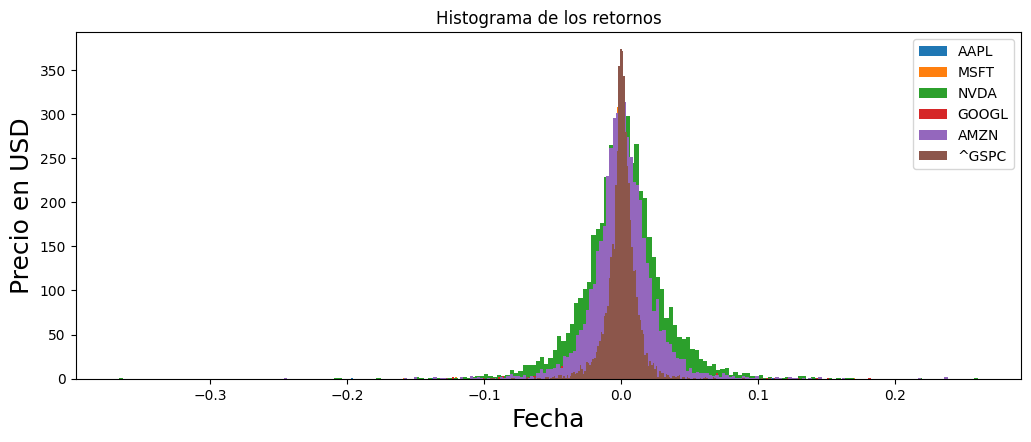

In [59]:
#visualizacion de los retornos logaritmicos

plt.figure(figsize=(12.2,4.5))
for i in data_log.columns.values:
    plt.hist( data_log[i],  label=i, bins = 200)
plt.title('Histograma de los retornos')
plt.xlabel('Fecha',fontsize=18)
plt.ylabel('Precio en USD',fontsize=18)
plt.legend(data_log.columns.values)
plt.savefig('plotretornosnormales.png', dpi=300, bbox_inches='tight')
plt.show()

In [74]:
#separamos los activos y el benchmark de mercado

df_activos =  data.loc[:, data.columns != '^GSPC']
df_activos = df_activos.pct_change()

df_benchmark1 =  data.loc[:, data.columns == '^GSPC']
df_benchmark1 = df_benchmark1.pct_change()


,^GSPC
Date,
1980-12-12,NaN
1980-12-15,0.001702
1980-12-16,0.008884
1980-12-17,0.017534
1980-12-18,0.000828
...,...
2024-08-05,-0.029969
2024-08-06,0.010354
2024-08-07,-0.007735




        R_i = R_f + \\beta_i (E(R_m) - R_f)

In [75]:
from pypfopt import expected_returns

retornos1 = expected_returns.capm_return(
    df_activos,
    market_prices = df_benchmark1,
    returns_data= True,
    risk_free_rate=0.07/100,
    frequency=252)
retornos1



,mkt
AAPL,0.108005
MSFT,0.110095
NVDA,0.169313
GOOGL,0.103401
AMZN,0.138667


In [78]:
#pesos del portafolio

def pesosPortafolio(dataframe):
    array = []
    for i in dataframe.columns:
        array.append(1/len(dataframe.columns))
    arrayFinal = np.array(array)
    return arrayFinal

pesos = pesosPortafolio(df_activos)
pesos

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [80]:
#Matriz de covarianza

df_cov = df_activos.cov()*252
df_cov

,AAPL,MSFT,NVDA,GOOGL,AMZN
AAPL,0.196022,0.061954,0.097205,0.051533,0.076352
MSFT,0.061954,0.112431,0.085259,0.046638,0.071563
NVDA,0.097205,0.085259,0.362152,0.067037,0.103548
GOOGL,0.051533,0.046638,0.067037,0.093973,0.059902
AMZN,0.076352,0.071563,0.103548,0.059902,0.316362


In [81]:
#Varianza del Portafolio

varianza_portafolio = pesos.T @ df_cov @pesos
"La varianza del portafolio es:" + " " + str(round(varianza_portafolio*100,1))+"%"

'La varianza del portafolio es: 10.1%'

In [83]:
#Desviacion estandar y/o volatilidad del portafolio

volatilidad_portafolio = np.sqrt(varianza_portafolio)
"La volatilidad del portafolio es:" + " " + str(round(volatilidad_portafolio*100,1))+"%"

'La volatilidad del portafolio es: 31.8%'

In [84]:
#Retorno del portafolio

retorno_portafolio = np.sum(pesos*retornos1)
'El retorno anual del portafolio es:' + ' ' + str(round(retorno_portafolio*100,3)) + '%'

'El retorno anual del portafolio es: 12.59%'

## Minimización de la varianza

In [87]:
ef = EfficientFrontier(retornos1, df_cov, weight_bounds=(0,1)) #con venta corta (-1,1)
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('AAPL', 0.11172), ('MSFT', 0.34899), ('NVDA', 0.0), ('GOOGL', 0.51552), ('AMZN', 0.02376)])
Expected annual return: 10.7%
Annual volatility: 26.8%
Sharpe Ratio: 0.32


(0.10708938663071944, 0.26814641369582165, 0.3247829625255081)

## Optimización para el Sharpe Ratio

In [89]:
ef = EfficientFrontier(retornos1, df_cov, weight_bounds=(0,1)) #con venta corta (-1,1)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('AAPL', 0.06309), ('MSFT', 0.28707), ('NVDA', 0.15814), ('GOOGL', 0.38244), ('AMZN', 0.10925)])
Expected annual return: 12.0%
Annual volatility: 28.9%
Sharpe Ratio: 0.35


(0.11988940085409241, 0.2889810941871535, 0.3456606776822597)

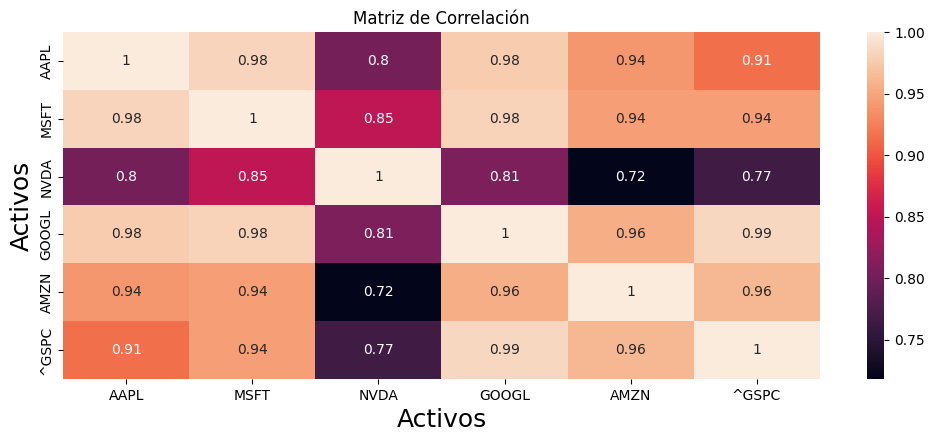

In [91]:
correlation_mat = data.corr()
plt.figure(figsize=(12.2,4.5))
sns.heatmap(correlation_mat, annot = True)
plt.title('Matriz de Correlación')
plt.xlabel('Activos',fontsize=18)
plt.ylabel('Activos',fontsize=18)
plt.show()